# ISYE 6740, Spring 2021, Homework 3
## Student: Homayoun Gerami

# 1. Order of faces using ISOMAP

## This question aims to reproduce the ISOMAP algorithm results in the original paper for ISOMAP, J.B. Tenenbaum, V. de Silva, and J.C. Langford, Science 290 (2000) 2319-2323 that we have also seen in the lecture as an exercise (isn't this exciting to go through the process of generating results for a high-impact research paper!). Choose the Euclidean distance (i.e., in this case, a distance in $\mathbb R^{4096}$) to construct the nearest neighbor graph—vertices corresponding to the images. Construct a similarity graph with vertices corresponding to the images, and tune the threshold $\epsilon$ so that each node has at least $K = 50$ neighbors (this approach corresponds to the so-called $\epsilon$-Isomap). 

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import coo_matrix
from scipy.spatial.distance import cdist
from sklearn.utils.graph import graph_shortest_path
from sklearn.neighbors import kneighbors_graph
import networkx as nx
from IPython.core.display import display, HTML
import warnings
import scipy.io


In [67]:
images = scipy.io.loadmat('isomap.mat')['images']

In [68]:
images.shape

(4096, 698)

In [69]:
images=images.T

## Choose the Euclidean distance (i.e., in this case, a distance in $\mathbb R^{4096}$) to construct the nearest neighbor graph—vertices corresponding to the images. Construct a similarity graph with vertices corresponding to the images, and tune the threshold $\epsilon$ so that each node has {\it at least} $K = 50$ neighbors (this approach corresponds to the so-called $\epsilon$-Isomap).

## a. Visualize the similarity graph 
 
## b. Implement the ISOMAP algorithm yourself to obtain a two-dimensional low-dimensional embedding. Plot the embeddings using a scatter plot, similar to the plots in lecture slides. Find a few images in the embedding space and show what these images look like. Comment on do you see any visual similarity among them and their arrangement, similar to what you seen in the paper?

### Q1-a and b)
#### I. Using e-ISOMAP appraoch, desigin the $\epsilon$ such a way, that each node has MINIMUM of 50 neighbors

In [70]:
#Compute the pairwise distance between images
distances = cdist(XA=images, XB=images, metric='euclidean')

In [71]:
distances.max()

34.687168481791545

In [72]:
### desigining the threshold as per the required minimum number of neighbors
def get_threshold(distances, num_nn):
    max_threshold = 0
    for i in range(distances.shape[0]):
        threshold = sorted(distances[i])[num_nn]
        if threshold > max_threshold:
            max_threshold = threshold
    return max_threshold

In [73]:
threshold = get_threshold(distances, 50)
threshold 

20.184898953140177

In [74]:
# setting the larger distances than the epsioln to Infinity
distances[distances>threshold] = np.inf

In [75]:
### sanity check for minimum number of neighbors  
min(np.count_nonzero(~np.isinf(distances), axis=1))

51

In [76]:
####Adjaceny Matrix from distances matrix, just for the visulaization purpose, networkx
A = distances
A[A>threshold] = 0.0


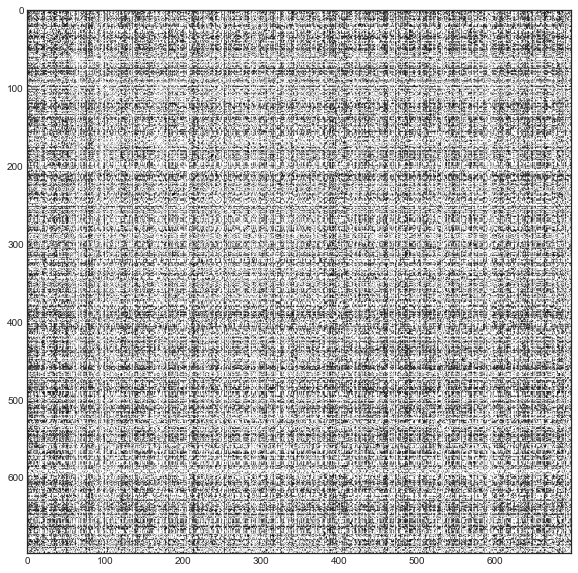

In [77]:
plt.figure(figsize=(10,10))
plt.imshow(A)

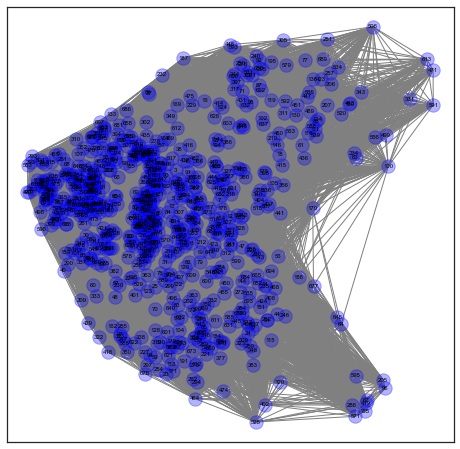

In [78]:
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

G = nx.from_numpy_matrix(np.array(A)) 
graph_pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, graph_pos, node_size=180, node_color='blue', alpha=0.3)
nx.draw_networkx_edges(G, graph_pos, edge_color='grey' )
nx.draw_networkx_labels(G, graph_pos, font_size=6, font_family='sans-serif')

plt.show()

In [79]:
#471, 595, 95, 622, 677,575, 396,305, 173,188

In [80]:
sample_nodes=[471, 595, 95, 622, 677,575, 396,305, 173,188]

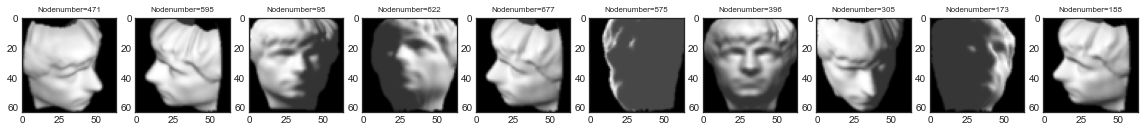

In [81]:
f, axarr=plt.subplots(1,10,figsize=(20,30))
for i in range(10):   
    #plt.subplots(1,i,figsize=(3,4))
    #axarr[i].imshow(images[:,sample_nodes[i]].reshape((64, 64)),cmap = 'gray')
    node_temp = images[sample_nodes[i],:].reshape((64, 64)).T
    axarr[i].imshow(node_temp ,cmap = 'gray')
    axarr[i].set_title("Nodenumber=%i" %(sample_nodes[i]),fontsize=8 )

####  I have selected the nodes from various part of the graph. One thing I noticed the nodes that are relatively closer, like 677 & 595, looks more similar. 

In [82]:
# Compute the shortest path graph D based on the nearest neighbors graph A:
D_e = graph_shortest_path(distances, directed=False)

In [83]:
# Compute the centering matrix H:
m=D_e.shape[0]
I = np.eye(N=D_e.shape[1])
H = I - 1/m * np.ones(I.shape)

In [84]:
# Compute the C matrix:
C_e = -0.5 * H @ D_e**2 @ H

In [85]:
E_e1, U_e1 = np.linalg.eigh(C_e)
idc1 = np.argsort(-E_e1)


In [86]:
E_e1 = E_e1[idc1]
U_e1 = U_e1[:,idc1]

In [87]:
U_e1[:,0].T@U_e1[:,0]

1.0000000000000004

In [88]:
proj_e1 =-U_e1[:,:2]* (E_e1[:2]**0.5)

In [89]:
proj_e1.shape

(698, 2)

In [90]:
# Plot our isomap

from matplotlib import offsetbox

def plot_components(proj, images=images, ax=None,
                    thumb_frac=0.05, cmap='gray',
                   xlabel="left-right facing",
                   ylabel="up-down facing"):
    
    fig = plt.figure(figsize=(40,15))
    ax = fig.add_subplot(1, 2, 1)
    
    plt.xlabel("left-right facing")
    plt.ylabel("up-down facing", labelpad=15).set_rotation(0)
    
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    m = proj[:, 0].shape[0]
    
    ax = fig.add_subplot(1, 2, 2)
    plt.xlabel("left-right facing")
    plt.ylabel("up-down facing", labelpad=15).set_rotation(0)
    
    
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    m = proj[:, 0].shape[0]
    min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) * 2 
    shown_images = np.array([2 * proj.max(0)])
    for i in range(m):
        dist = np.sum((proj[i] - shown_images) ** 2, 1)
        if np.min(dist) < min_dist_2:
                # don't show points that are too close
            continue
        shown_images = np.vstack([shown_images, proj[i]])
        imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(images[i].reshape((64,64)).T, cmap=cmap,zoom=0.75),proj[i])
        ax.add_artist(imagebox)

######### e-Isomap, Euclidean distance, with (right) & without(left) images overlain #######


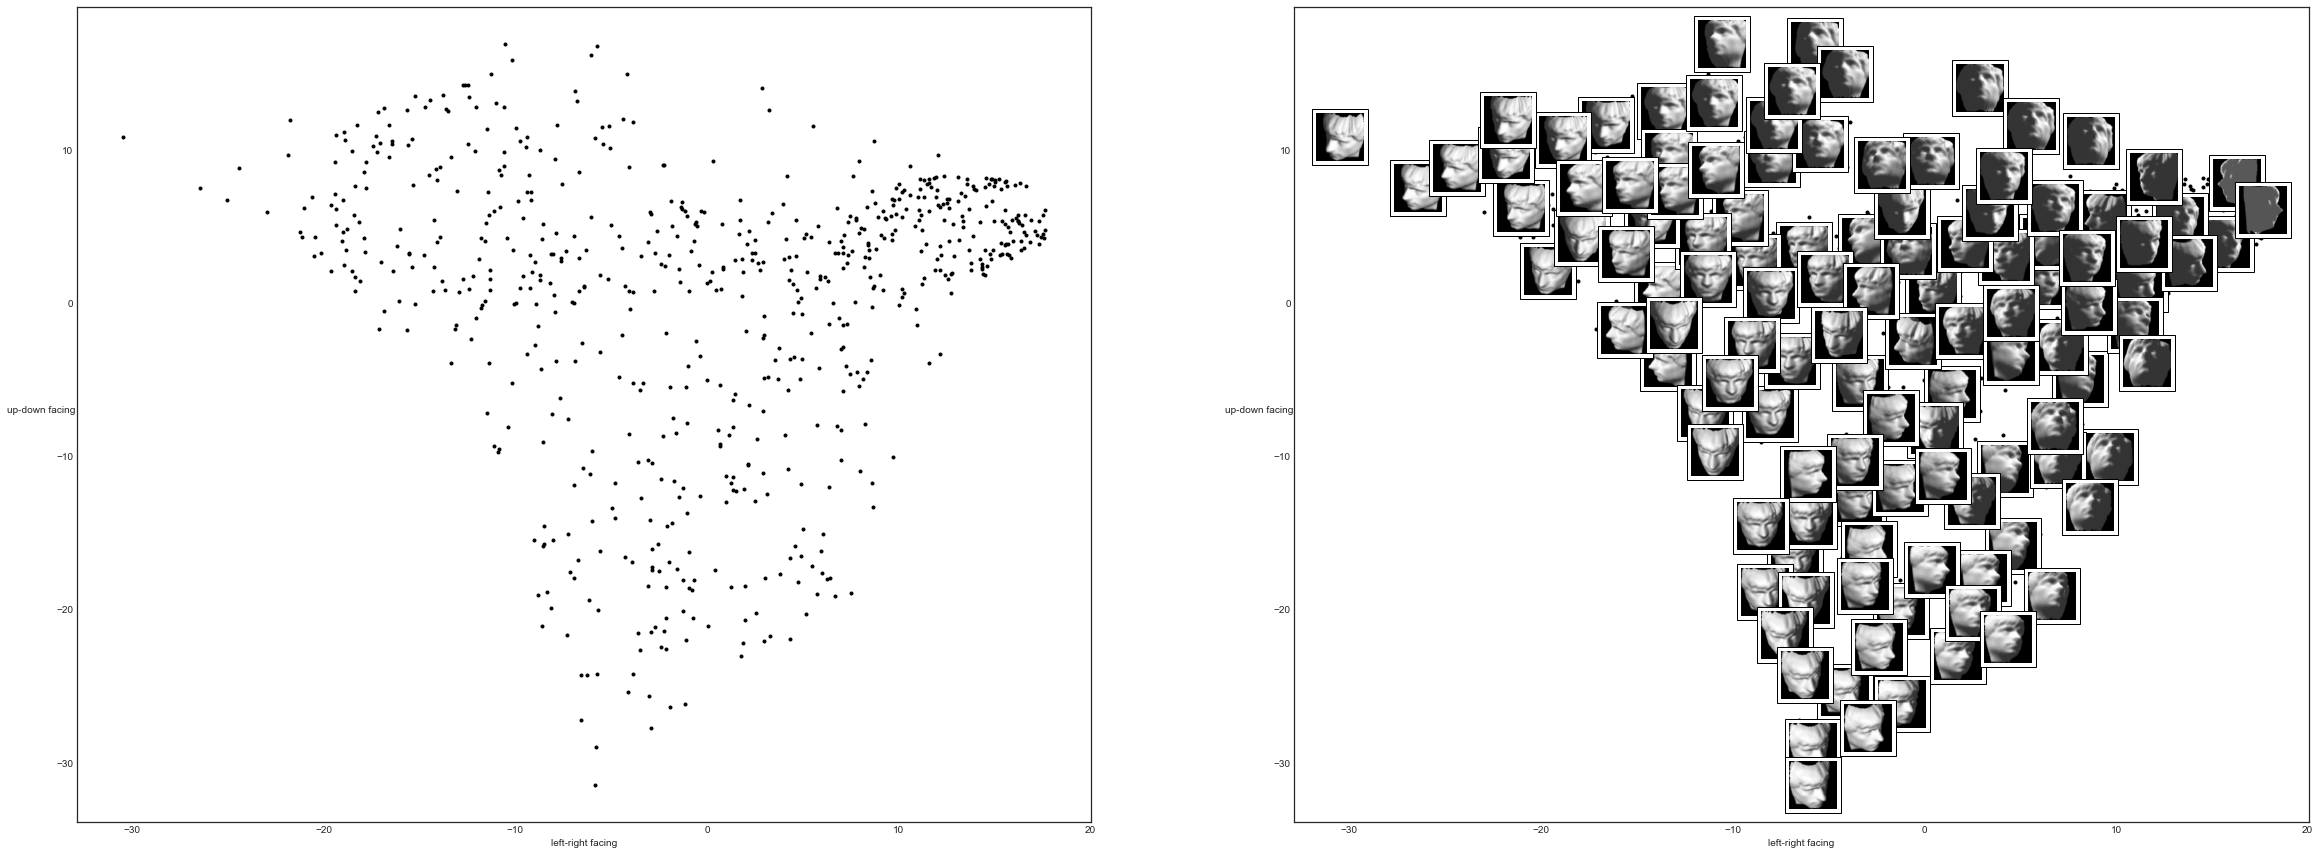

In [91]:
print('######### e-Isomap, Euclidean distance, with (right) & without(left) images overlain #######')
#plot_components(proj_e1, images )
plot_components(proj_e1, images )

#### eventough the result from the e-Isomap approach arranged reasoably ok, but for sure it is not good enough, as we can see a few images that they were not supposed to appear so close to each other. As per further investigation, decided to test the k-Isomap approach:  

#### II. Using k-ISOMAP appraoch, each node will have just desired number of neighbors, in this case k=50

In [213]:
#Compute the pairwise distance between images
distances = cdist(XA=images, XB=images, metric='euclidean')

In [234]:
##### now with the k-ISOMAP approach, every node will have just and only K neighbors
A = np.zeros_like(distances)
num_neighbors=50
for i in range(distances.shape[0]):
    neighbors = np.argsort(distances[i,:])[:num_neighbors+1]
    A[i,neighbors] = distances[i,neighbors]
    #A[neighbors,i] = distances[neighbors,i]

In [235]:
len(neighbors)


51

In [236]:
A[0]

array([ 0.        ,  0.        ,  6.74323967,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 10.03619136,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  8.50263115,
        0.        , 10.76684529,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 12.02054383,  0.        ,  0.        ,  0.        ,
        8.21371473,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  9.2936345 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , 11.09018356,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [237]:
for i in range(A.shape[1]):
    print(sum(x > 0 for x in A[i]))
#max(np.count_nonzero(A[0]))

50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
50
5

In [238]:
A

array([[0.        , 0.        , 6.74323967, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [6.74323967, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [239]:
np.mean(A)

0.7868295579548179

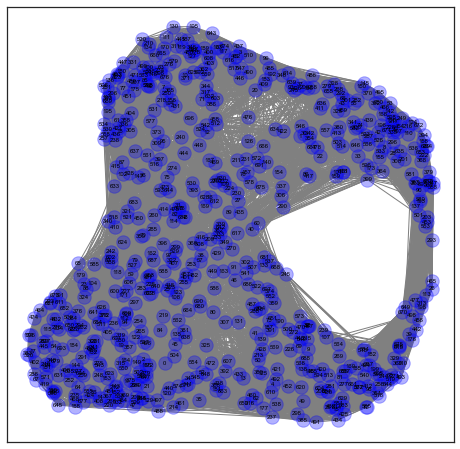

In [240]:
#import networkx as nx
#import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

G = nx.from_numpy_matrix(np.array(A)) 
graph_pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, graph_pos, node_size=180, node_color='blue', alpha=0.3)
nx.draw_networkx_edges(G, graph_pos, edge_color='grey' )
nx.draw_networkx_labels(G, graph_pos, font_size=6, font_family='sans-serif')

plt.show()

In [241]:
D = graph_shortest_path(A)

#C = -1/(2*m) * H @ D**2 @ H
C = -1/(2) * H @ D**2 @ H    
vals, vecs = np.linalg.eigh(C)
sorted_vals = vals[np.argsort(-vals)]
sorted_vecs = vecs[:,np.argsort(-vals)]
    
# Normalize the leading eigenvectors:
proj_k1 = -sorted_vecs[:,:2] * np.sqrt(sorted_vals[:2])

In [242]:
sorted_vals[:2]


array([213014.3191962 , 154954.45305986])

######### k-Isomap, Euclidean distance #######


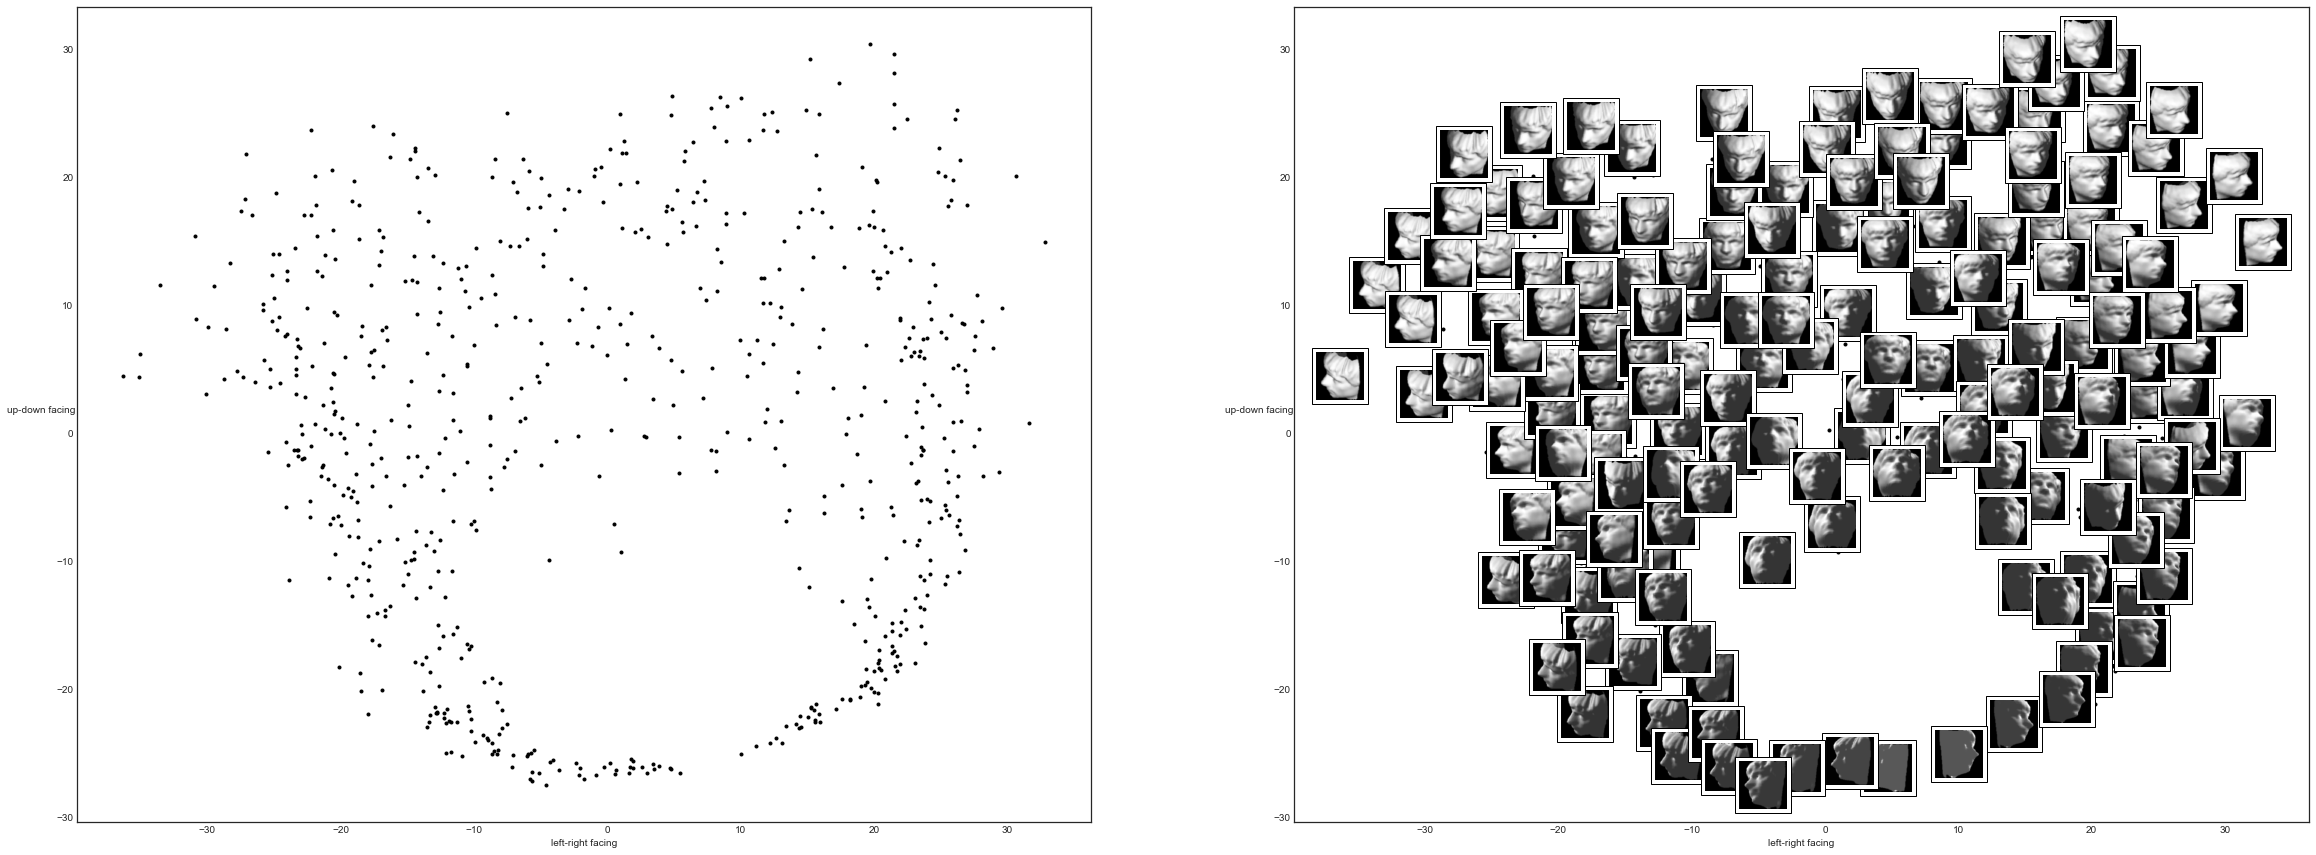

In [243]:
print('######### k-Isomap, Euclidean distance #######')
#plot_components(proj_k1 , images=images)
plot_components(proj_k1 )

### Certainly result from the k-Isomap make a much better sense to me than e_Isomap, and I continue with this apparoach for the other part of the Q1. 

## c. Now choose $\ell_1$ distance (or Manhattan distance) between images (recall the definition from ``Clustering'' lecture)). Repeat the steps above. Use $\epsilon$-ISOMAP to obtain a $k=2$ dimensional embedding. Present a plot of this embedding. Do you see any difference by choosing a different similarity measure by comparing results in Part (b) and Part (c)?

In [109]:
distances = cdist(XA=images, XB=images, metric='cityblock')
A = np.zeros_like(distances)
num_neighbors=50
for i in range(distances.shape[0]):
    neighbors = np.argsort(distances[i,:])[:num_neighbors+1]
    A[i,neighbors] = distances[i,neighbors]
    A[neighbors,i] = distances[neighbors,i]
D = graph_shortest_path(A)

C = -1/(2*m) * H @ D**2 @ H
    
vals, vecs = np.linalg.eigh(C)
sorted_vals = vals[np.argsort(-vals)]
sorted_vecs = vecs[:,np.argsort(-vals)]
    
proj_k_m = -sorted_vecs[:,:2] * np.sqrt(sorted_vals[:2])

######### k-Isomap, Manhattan distance#######


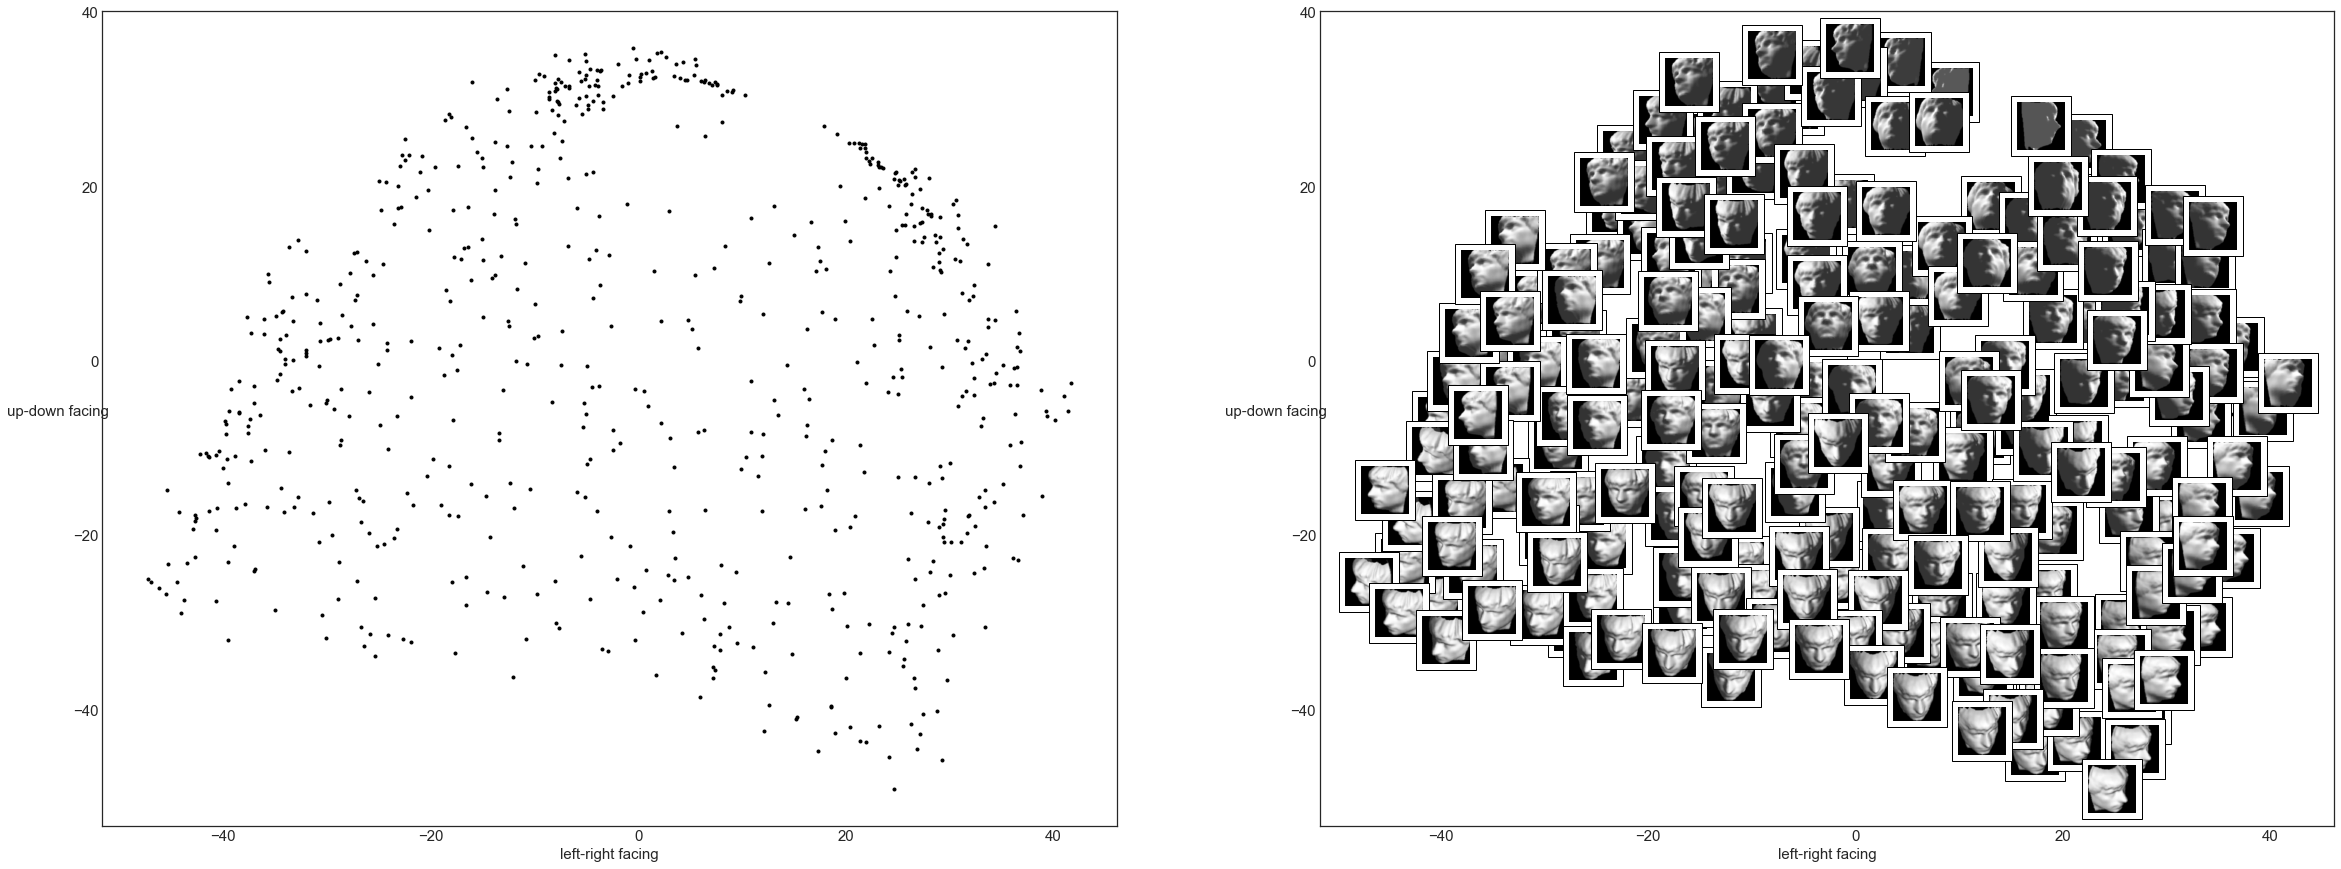

In [119]:
print('######### k-Isomap, Manhattan distance#######')
plot_components(proj_k_m , images=images)

###  The results with manhattan distance is fine but  Eucledian distance is superior.

## d. Perform PCA  on the images and project them into the top 2 principal components. Again show them on a scatter plot. Explain whether or you see a more meaningful projection using ISOMAP than PCA.

In [49]:
mean_images= np.mean(images, axis=0)

In [50]:
mean_images.shape

(4096,)

In [51]:
centered_images = images-mean_images


In [52]:
centered_images.shape

(698, 4096)

In [53]:
C_pca = np.cov(centered_images, rowvar=False)
E_pca, U_pca = np.linalg.eigh(C_pca)


In [54]:
idc1 = np.argsort(-E_pca)
E_pca = E_pca[idc1]
U_pca = U_pca[:,idc1] # sort columns

In [56]:
proj_pca= -centered_images @ U_pca[:,:2]


#########PCA on images#######


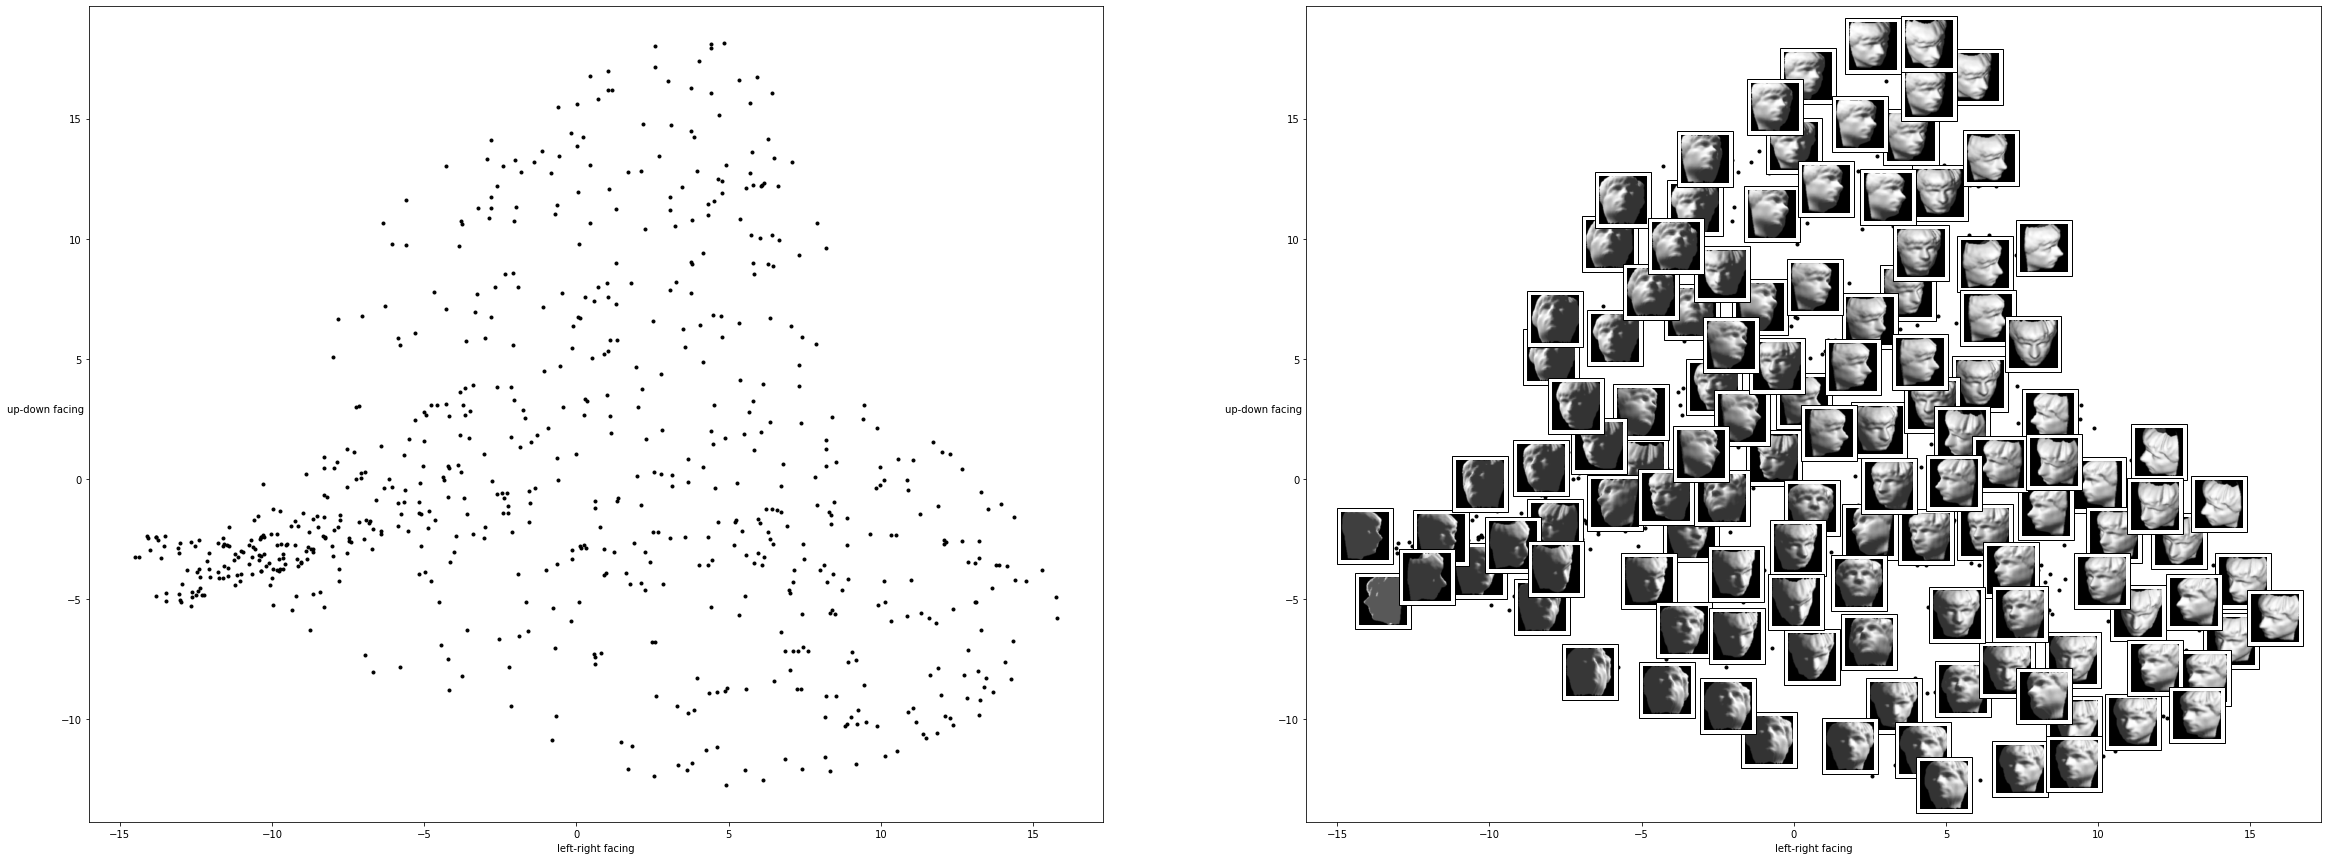

In [57]:
print('#########PCA on images#######')
plot_components(proj_pca , images=images)

### As expected, the k- ISOMAP  results is certinly better than the PCA for this case.   

# 2. Density estimation: Psychological experiments. 

### We will use this data to study whether or not the two brain regions are likely to be independent of each other and considering different types of political view. For this question you can use the proper package for histogram and KDE; no need to write your own.The datset 90pol.csv contains information on 90 university students who participated in a psychological experiment designed to look for relationships between the size of different regions of the brain and political views.  The variables amygdala and acc indicate the volume of two particular brain regions known to be involved in emotions and decision-making, the amygdala and the anterior cingulate cortex; more exactly, these are residuals from the predicted volume, after adjusting for height, sex, and similar body-type variables.  The variable orientation gives the students’ locations on a five-point scale from 1 (very conservative) to 5 (very liberal).  Note that in the dataset, we only have observations for orientation from 2 to5. 


$$x = \begin{bmatrix}x_1\\x_2\end{bmatrix}\in \mathbb R^2$$

where $x_1$ and $x_2$ are the two dimensions respectively $$K(x) = \frac{1}{\sqrt {2\pi}} e^{-\frac{(x_1^2 + x_2^2)}{2}}$$ Recall in this case, the kernel density estimator (KDE) for a density is given by

 $$p(x) = \frac 1 m \sum_{i=1}^m \frac 1 h
 K\left(
 \frac{x^i - x}{h}
 \right)$$
 


### a.  Form the 1-dimensional histogram and KDE to estimate the distributions of  amygdala  and  acc , respectively. For this question, you can ignore the variable  orientation. Decide on a suitable number of bins so you can see the shape of the distribution clearly. Set an appropriate kernel bandwidth $h >0$. For example. for one-dimensional KDE, you are welcome to use a rule-of-thumb bandwidth estimator.

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn-white')

In [8]:
df = pd.read_csv("n90pol.csv")

In [9]:
df.head()

amygdala     acc  orientation
0    0.0051 -0.0286            2
1   -0.0674  0.0007            3
2   -0.0257 -0.0110            3
3    0.0504 -0.0167            2
4    0.0125 -0.0005            5

In [61]:
len(df)

90

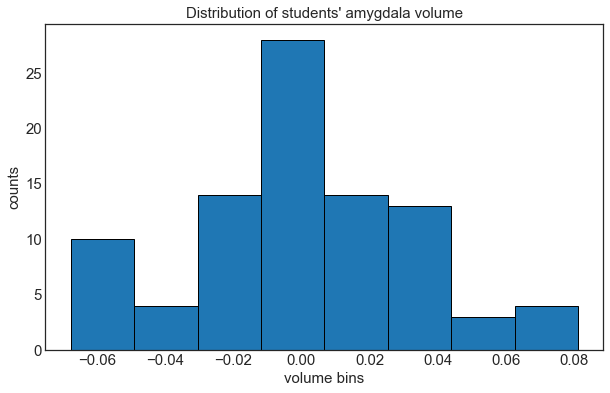

In [62]:
# 1-D histogram:

SMALL_SIZE = 4
MEDIUM_SIZE = 6
BIGGER_SIZE = 15

plt.figure(figsize=(10, 6))
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE) 
plt.rc('xtick', labelsize=BIGGER_SIZE) 

plt.hist(df['amygdala'], edgecolor='black', bins=8)
# Add title and axis names
plt.title("Distribution of students' amygdala volume")
plt.xlabel('volume bins')
plt.ylabel('counts')

plt.show()

#### 8 bins looks reasoable for amygdala

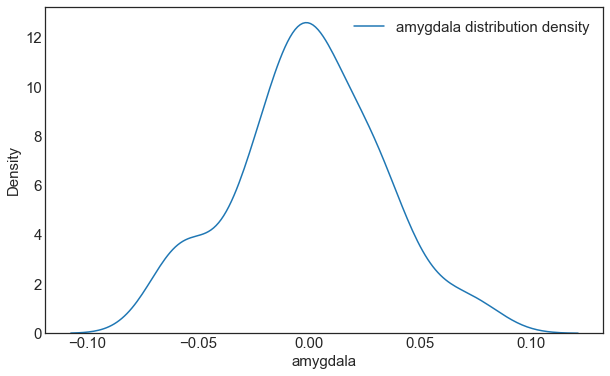

In [63]:
import seaborn as sns
# 1-D KDE:

fig, ax = plt.subplots(figsize=(10, 6))
g_amygdala = sns.kdeplot(data=df["amygdala"])
ax.legend(['amygdala distribution density'])

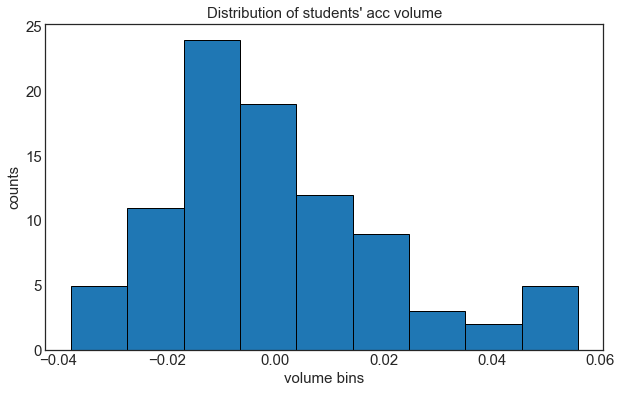

In [64]:
# 1-D histogram:

SMALL_SIZE = 4
MEDIUM_SIZE = 6
BIGGER_SIZE = 15

plt.figure(figsize=(10, 6))
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE) 
plt.rc('xtick', labelsize=BIGGER_SIZE) 

plt.hist(df['acc'], edgecolor='black', bins=9)
# Add title and axis names
plt.title("Distribution of students' acc volume")
plt.xlabel('volume bins')
plt.ylabel('counts')

plt.show()

#### 9 bins looks reasoable for acc

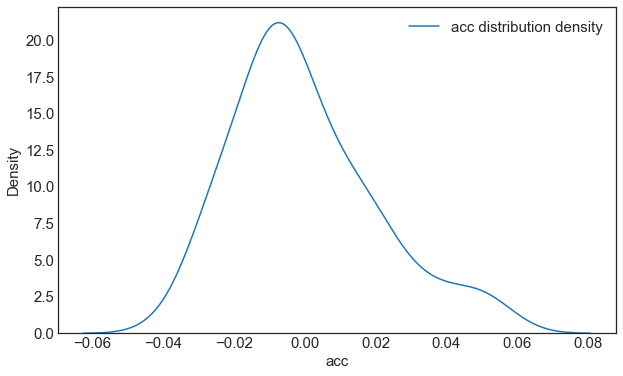

In [65]:
# 1-D KDE:

fig, ax = plt.subplots(figsize=(10, 6))
g_acc = sns.kdeplot(data=df["acc"])
ax.legend(['acc distribution density'])

### b. Form 2-dimensional histogram for the pairs of variables (amygdala, acc). Decide on a suitable number of bins so you can see the shape of the distribution clearly. 

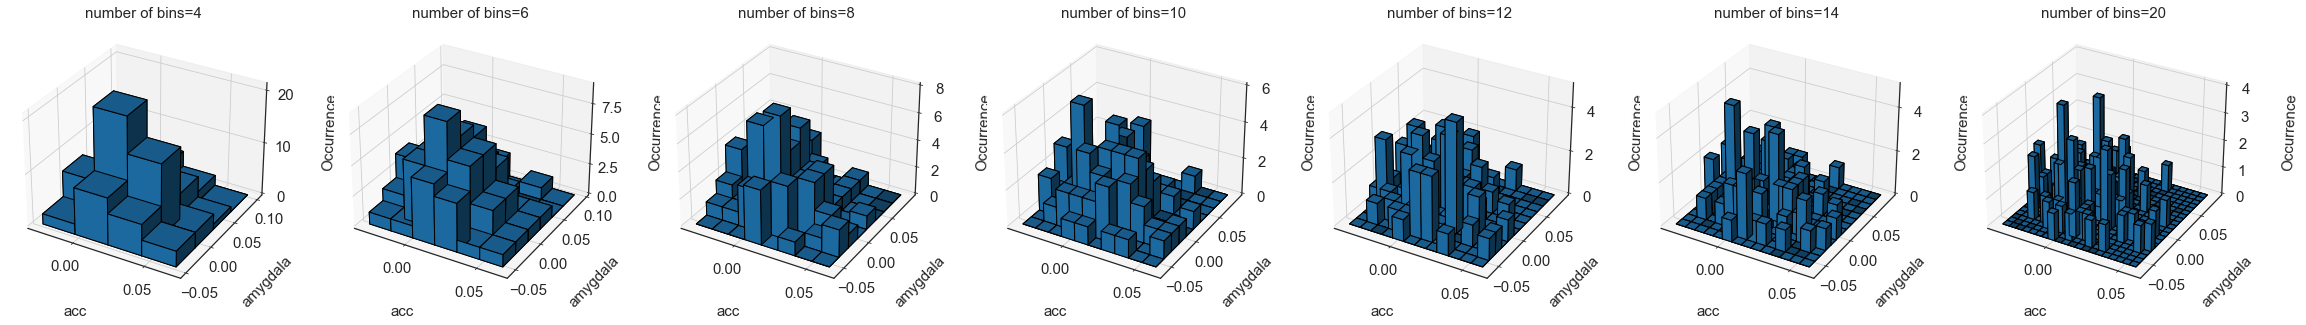

In [66]:
n_bins=[4,6,8,10,12,14,20]
#fig = plt.figure(figsize=plt.figaspect(0.1))
fig = plt.figure(figsize=(40,60))
for i in range (len(n_bins)):
    ax = fig.add_subplot(1, len(n_bins), i+1, projection='3d')

    # Creating plot 
    hist, xedges, yedges = np.histogram2d(df['acc'].values, df["amygdala"].values, bins=n_bins[i])
  
    # Construct arrays for the anchor positions of the 5 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + xedges[1:], yedges[:-1] + yedges[1:])
    xpos = xpos.flatten()/2.
    ypos = ypos.flatten()/2.
    zpos = np.zeros_like(xpos)

    # Construct arrays with the dimensions for the 5 bars.
    dx = dy = 0.5 * np.ones_like(zpos)
    dz = hist.ravel()

    dx = xedges [1] - xedges [0]
    dy = yedges [1] - yedges [0]
    dz = hist.flatten()
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, edgecolor='black')

    ax.set_xlabel('acc', labelpad=20)
    ax.set_ylabel('amygdala', labelpad=20)
    ax.set_zlabel('Occurrence', labelpad=20)
    plt.locator_params(axis='y', nbins=4)
    plt.locator_params(axis='x', nbins=4)
    plt.locator_params(axis='z', nbins=4)
    ax.title.set_text("number of bins=%i" %(n_bins[i]))  

#### I think either 8 or 10 bins is suitable for ploting this 2D histograms. My judgement is based on that we should aviod having empty or low populated  bins, especially around center of data.  

### c. Use kernel-density-estimation (KDE) to estimate the 2-dimensional density function of (amygdala, acc) (this means for this question, you can ignore the variable orientation). Set an appropriate kernel bandwidth $h >0$. Please show the two-dimensional KDE (e.g., two-dimensional heat-map, two-dimensional contour plot, etc.) Please explain based on the results, can you infer that the two variables amygdala, acc are likely to be independent or not?

In [67]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV 

In [68]:
def get_2d_grid(x, y):
    # create grid of sample locations (default: 100x100)
    # Define the borders
    deltaX = (max(x) - min(x))/10
    deltaY = (max(y) - min(y))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX
    ymin = min(y) - deltaY
    ymax = max(y) + deltaY

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    return xmin, xmax, ymin, ymax, xx, yy

In [69]:
grid = GridSearchCV(KernelDensity(kernel = 'gaussian'),{'bandwidth': np.linspace(0.00001, 0.5, 200)}, cv = 5)

In [72]:
x = df["amygdala"].values
y = df['acc'].values

xmin, xmax, ymin, ymax, xx, yy = get_2d_grid(x, y)

xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
xy_train  = np.vstack([y, x]).T
grid.fit(xy_train)

GridSearchCV(cv=5, estimator=KernelDensity(),
             param_grid={'bandwidth': array([1.00000000e-05, 2.52251256e-03, 5.03502513e-03, 7.54753769e-03,
       1.00600503e-02, 1.25725628e-02, 1.50850754e-02, 1.75975879e-02,
       2.01101005e-02, 2.26226131e-02, 2.51351256e-02, 2.76476382e-02,
       3.01601508e-02, 3.26726633e-02, 3.51851759e-02, 3.76976884e-02,
       4.02102010e-02, 4.27227136e-02, 4.523...
       4.42212211e-01, 4.44724724e-01, 4.47237236e-01, 4.49749749e-01,
       4.52262261e-01, 4.54774774e-01, 4.57287286e-01, 4.59799799e-01,
       4.62312312e-01, 4.64824824e-01, 4.67337337e-01, 4.69849849e-01,
       4.72362362e-01, 4.74874874e-01, 4.77387387e-01, 4.79899899e-01,
       4.82412412e-01, 4.84924925e-01, 4.87437437e-01, 4.89949950e-01,
       4.92462462e-01, 4.94974975e-01, 4.97487487e-01, 5.00000000e-01])})

#### optimum bandwidth after doing cross-validation: 

In [73]:

print(grid.best_params_)

{'bandwidth': 0.01006005025125628}


In [74]:
z = np.exp(grid.best_estimator_.score_samples(xy_sample))
kde = KernelDensity(kernel='gaussian', bandwidth=grid.best_params_['bandwidth']).fit(xy_train)
kde.fit(xy_train)

KernelDensity(bandwidth=0.01006005025125628)

In [75]:
# score_samples() returns the log-likelihood of the samples
z = np.exp(kde.score_samples(xy_sample))
z = np.reshape(z, xx.shape)

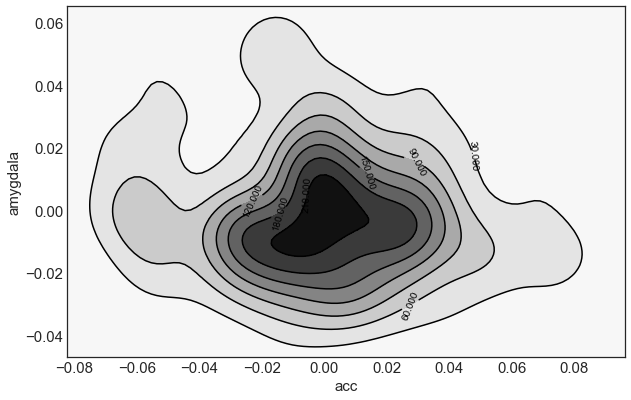

In [76]:
fig, ax = plt.subplots(figsize=(10, 30))
# Contourf plot
cfset = ax.contourf(xx, yy, z)
ax.imshow(np.rot90(z), extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, z, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('acc')
ax.set_ylabel('amygdala')
plt.show()

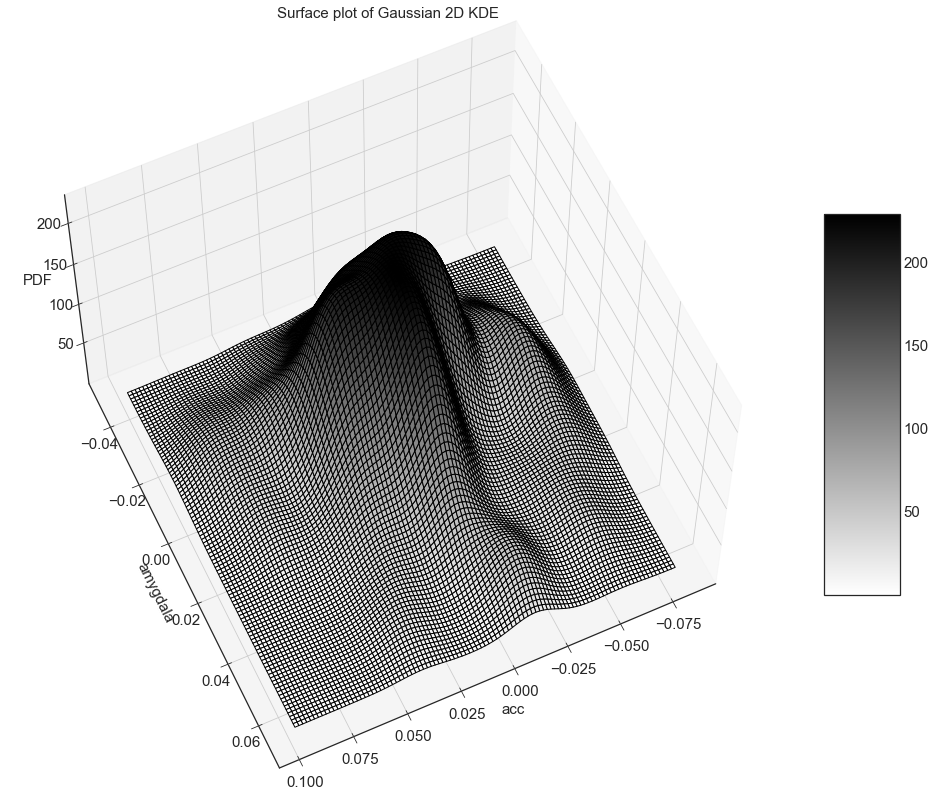

In [77]:
# 3d kde plot:

fig = plt.figure(figsize=(20, 14))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, z, rstride=1, cstride=1, cmap='binary', edgecolor='black')
ax.set_xlabel('acc')
ax.set_ylabel('amygdala')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 65)

#### we just looked at the p(amygdala,acc), and they don't apprear independent. but to answer this preceisly, we can also establish the p(amygdala) × p(acc) plot and compare that with the earlier plot. If those two are not identical then thery are surenly NOT independent.     

In [78]:
def get_1d_grid(x):
    # create grid of sample locations (default: 100x100)
    # Define the borders
    deltaX = (max(x) - min(x))/10
    xmin = min(x) - deltaX
    xmax = max(x) + deltaX

    xx = np.linspace(start=xmin, stop=xmax, num=100)
    return xx

In [79]:
# p(amygdala) × p(acc)

kde_acc = KernelDensity(bandwidth=0.01).fit(df["acc"].values[:, None])
dens_acc = np.exp(kde_acc.score_samples(get_1d_grid(df["acc"].values[:, None])))

kde_amygdala = KernelDensity(bandwidth=0.01).fit(df["amygdala"].values[:, None])
dens_amygdala = np.exp(kde_amygdala.score_samples(get_1d_grid(df["amygdala"].values[:, None])))

prod_kdes = np.outer(dens_acc, dens_amygdala)

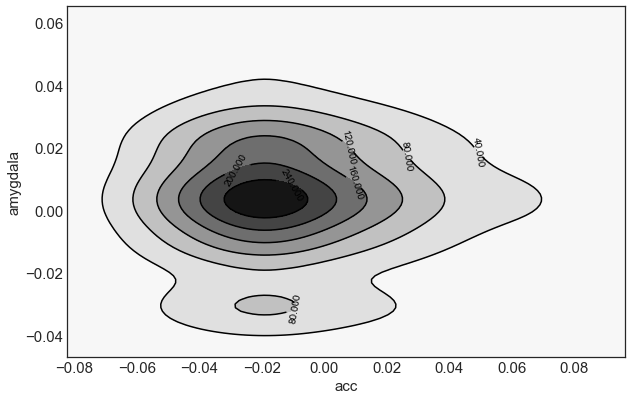

In [80]:
# plot for p(amygdala) × p(acc)

fig, ax = plt.subplots(figsize=(10, 30))
# Contourf plot
cfset = ax.contourf(xx, yy, prod_kdes)
ax.imshow(np.rot90(prod_kdes), extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, prod_kdes, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('acc')
ax.set_ylabel('amygdala')
plt.show()

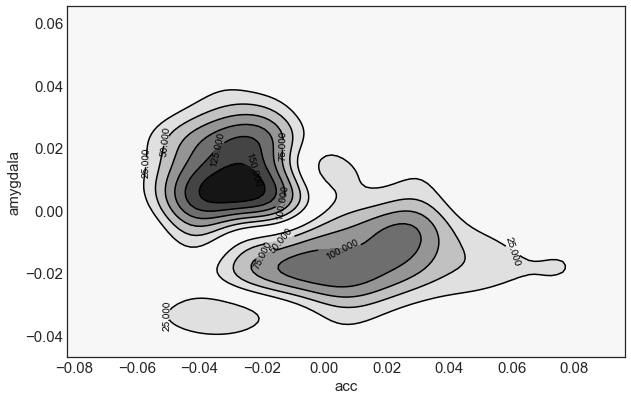

In [81]:
# error map |p(amygdala, acc)−p(amygdala)p(acc)|:

error = np.abs(z - prod_kdes)
fig, ax = plt.subplots(figsize=(10, 30))
# Contourf plot
cfset = ax.contourf(xx, yy, error)
ax.imshow(np.rot90(error), extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, error, colors='k')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('acc')
ax.set_ylabel('amygdala')
plt.show()

### as per the above error plot,the amygdala & acc are not independent.  

### d. We will consider the variable \textsf{orientation} and consider conditional distributions. Please plot the estimated conditional distribution of \textsf{amygdala} conditioning on political \textsf{orientation}: $p(\textsf{amygdala}|\textsf{orientation}=c)$, $c = 2, \ldots, 5$, using KDE. Set an appropriate kernel bandwidth $h >0$.  Do the same for the volume of the \textsf{acc}: plot $p(\textsf{acc}|\textsf{orientation}=c)$, $c = 2, \ldots, 5$ using KDE. (Note that the conditional distribution can be understood as fitting a distribution for the data with the same $\textsf{orientation}$. Thus you should plot 8 one-dimensional distribution functions in total for this question.) Now please explain based on the results, can you infer that the conditional distribution of  \textsf{amygdala} and \textsf{acc}, respectively, are different from $c = 2, \ldots, 5$? This is a type of scientific question one could infer from the data: Whether or not there is a difference between brain structure and political view.

In [82]:


def get_plots(axs, ind_x, ind_y, i, dat, var='amygdala'):
    sns.kdeplot(data=dat[dat['orientation'] == i][var].values, ax=axs[ind_x, ind_y])
    axs[ind_x, ind_y].set_title('p({} | orientation = {})'.format(var, i))

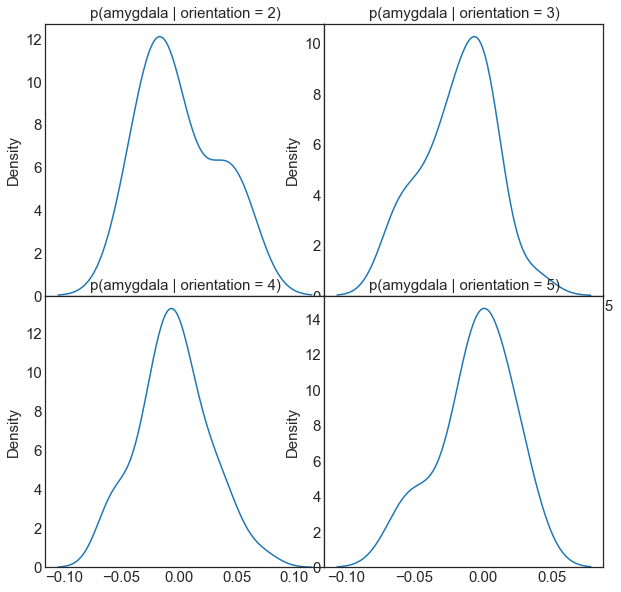

In [83]:
fig, axs = plt.subplots(2, 2, gridspec_kw={'wspace':0, 'hspace':0},
                        squeeze=True, figsize=(10, 10))
    
get_plots(axs, 0, 0, 2, df, var='amygdala')
get_plots(axs, 0, 1, 3, df, var='amygdala')
get_plots(axs, 1, 0, 4, df, var='amygdala')
get_plots(axs, 1, 1, 5, df, var='amygdala')
plt.show()

In [84]:
def get_plots(axs, ind_x, ind_y, i, dat, var='acc'):
    sns.kdeplot(data=dat[dat['orientation'] == i][var].values, ax=axs[ind_x, ind_y])
    axs[ind_x, ind_y].set_title('p({} | orientation = {})'.format(var, i))

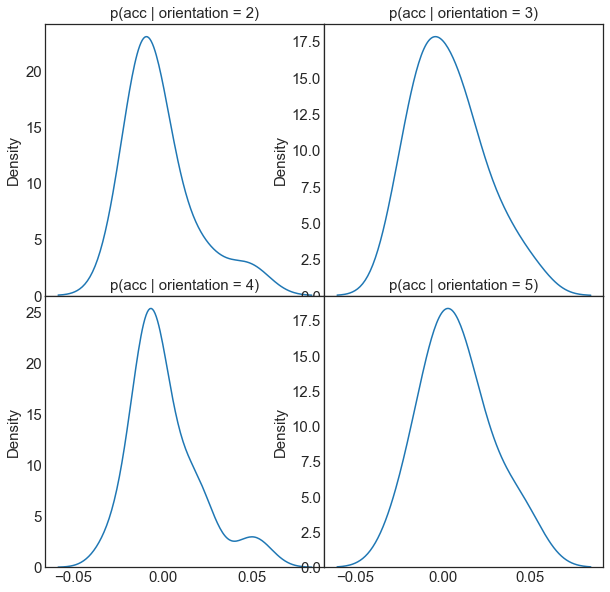

In [85]:
fig, axs = plt.subplots(2, 2, gridspec_kw={'wspace':0, 'hspace':0},
                        squeeze=True, figsize=(10, 10))
    
get_plots(axs, 0, 0, 2, df, var='acc')
get_plots(axs, 0, 1, 3, df, var='acc')
get_plots(axs, 1, 0, 4, df, var='acc')
get_plots(axs, 1, 1, 5, df, var='acc')
plt.show()

dat[dat['orientation'] == 2][acc].values

In [86]:
df[df['orientation'] == 2]['acc'].values

array([-0.0286, -0.0167, -0.0224, -0.0023, -0.0377, -0.0278, -0.0255,
        0.0363, -0.0241, -0.0124, -0.0186, -0.0242,  0.012 ])

In [87]:
#### means calculation:
mean ={}
for c in [2,3,4,5]:
    for attribute in ['amygdala','acc']:
        temp=df[df['orientation'] == c][attribute].values
        mean_temp=round(np.mean(temp),3)
        mean [attribute,c] = mean_temp
        #print ("MEAN  {}'s values with  oreintation:{}   is {}". format(attribute, c, mean_temp ))


In [88]:
mean

{('amygdala', 2): 0.019,
 ('acc', 2): -0.015,
 ('amygdala', 3): 0.001,
 ('acc', 3): 0.002,
 ('amygdala', 4): -0.005,
 ('acc', 4): 0.001,
 ('amygdala', 5): -0.006,
 ('acc', 5): 0.008}

| Attribute's Mean| C=2 | C=3 |C=4 | C=5 |  
| --- | --- | --- |--- | --- |
| amygdala| 0.019 | 0.001 |-0.005 | -0.006 |
| acc| -0.015 | 0.002 |0.001 | 0.008 |

### e. Again we will consider the variable orientation. We will estimate the conditional joint distribution of the volume of the amygdala and acc, conditioning on  a function of political orientation: $p(\textsf{amygdala}, \textsf{acc}|\textsf{orientation}=c)$, $c = 2, \ldots, 5$. You will use two-dimensional KDE to achieve the goal; et an appropriate kernel bandwidth $h >0$. Please show the two-dimensional KDE (e.g., two-dimensional heat-map, two-dimensional contour plot, etc.). Please explain based on the results, can you infer that the conditional distribution of two variables (amygdala, acc) are different from $c = 2, \ldots, 5$? This is a type of scientific question one could infer from the data: Whether or not there is a difference between brain structure and political view.

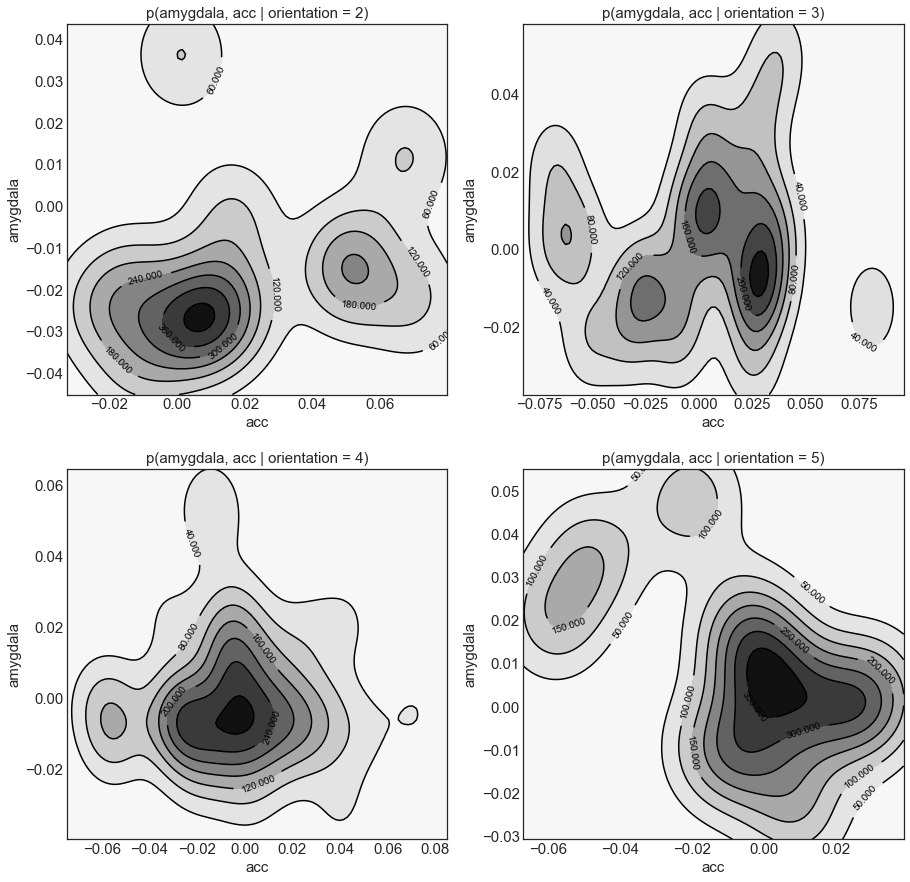

In [108]:


def get_3d_plots(axs, ind_x, ind_y, i, dat):
    x = df["amygdala"].values
    y = df['acc'].values

    xmin, xmax, ymin, ymax, _ , _ = get_2d_grid(x, y)
    
    x = df[df['orientation'] == i]["amygdala"].values
    y = df[df['orientation'] == i]['acc'].values
    
    _, _, _, _, xx , yy = get_2d_grid(x, y)
    
    
    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T
    
    kde = KernelDensity(kernel='gaussian', bandwidth=grid.best_params_['bandwidth']).fit(xy_train)
    z = np.exp(kde.score_samples(xy_sample))
    z = np.reshape(z, xx.shape)
    cfset = axs[ind_x, ind_y].contourf(xx, yy, z)
    cset = axs[ind_x, ind_y].contour(xx, yy, z, colors='k')
    axs[ind_x, ind_y].clabel(cset, inline=1, fontsize=10)
    axs[ind_x, ind_y].set_xlabel('acc')
    axs[ind_x, ind_y].set_ylabel('amygdala')
    axs[ind_x, ind_y].set_title('p(amygdala, acc | orientation = {})'.format(i))

fig, axs = plt.subplots(2, 2, gridspec_kw={'wspace':0.2, 'hspace':0.2},
                        figsize=(15, 15))
    
get_3d_plots(axs, 0, 0, 2, df)
get_3d_plots(axs, 0, 1, 3, df)
get_3d_plots(axs, 1, 0, 4, df)
get_3d_plots(axs, 1, 1, 5, df)
plt.show()

#### 2D joint distribution looks different for various orientation values. I however think that maybe 90 observations is not sufficent to conclude whether there is such noticeable difference between brain structure and political view.   